## Library 

In [58]:
# Basic
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle
import os
from collections import OrderedDict
import warnings
pd.set_option('display.max_rows', None)
palette: str = "husl"
grouped: str = "account_type"
default_value: str = "unknown"
warnings.filterwarnings('ignore')

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl


## Function Created 


In [11]:
# Distribution
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [12]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [13]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [14]:
# encoding
def convert_bool_to_int(data: pd.DataFrame, boolean_cols: list):
    try:
        for col in boolean_cols:
            data[col] = data[col].astype(int)
    except Exception as e:
        print(e)
    return data

In [15]:
# 类似于similarity，定义popularity=log(1+friends_cnt)*log(1+followers_cnt)
def popularity_metric(friends_count: int, followers_count: int):
    return np.round(np.log(1+friends_count) * np.log(1+followers_count), 3)
def compute_popularity_metric(row):
    return popularity_metric(friends_count=row["friends_count"],
                             followers_count=row["followers_count"])

In [16]:
def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    try:
        labels: list = df[column].unique().tolist()
        colors: list = sns.color_palette(palette, len(labels))
        data_labels: dict = dict(zip(labels, colors))
    except Exception as e:
        logger.error(e)
    return data_labels

In [17]:
def plot_multiple_histograms(data: pd.DataFrame,
                             grouped_col: str,
                             target_col: str,
                             data_labels: dict):
    # Plot
    plt.figure(figsize=(12, 10))
    title = "\n"
    labels: list = list(data_labels.keys())
    for j, i in enumerate(labels):
        x = data.loc[data[grouped_col] == i, target_col]
        mu_x = round(float(np.mean(x)), 3)
        sigma_x = round(float(np.std(x)), 3)
        ax = sns.distplot(x, color=data_labels.get(i), label=i, hist_kws=dict(alpha=.1),
                          kde_kws={'linewidth': 2})
        ax.axvline(mu_x, color=data_labels.get(i), linestyle='--')
        ax.set(xlabel=f"{target_col.title()}", ylabel='Density')
        title += f"Parameters {str(i)}: $G(\mu=$ {mu_x}, $\sigma=$ {sigma_x} \n"
        ax.set_title(title)
    plt.legend(title="Account Type")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [18]:
def create_time_bar(df): # 账号创建时间对比柱状图
    df_tmp = df.groupby(['created_at', 'account_type'])['created_at'].count().unstack('account_type')
    df_tmp.plot(kind='bar', stacked=True, width=0.9, align='edge')
    plt.ylabel('number of accounts created')
    plt.show()

In [19]:
def verified_bar(df): # verified对比柱状图
    df_tmp = df.groupby(['account_type', 'verified'])['account_type'].count().unstack('verified')
    df_tmp.plot(kind='bar', stacked=True)
    plt.show()

In [20]:
def encode_bot_or_not(row): # y的编码
    if row['account_type'] == 'human':
        return 0
    return 1

In [21]:
def data_to_dataframe(): # 预处理
    Url = "https://raw.githubusercontent.com/chenchencherry/CS5344_twitter_bots_eda/main/twitter_human_bots_dataset.csv"
    df = pd.read_csv(Url)
    
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    # 只focus英文语言78;'
    # df = df.loc[df['lang'] == 'en', :]

    boolean_cols: list = ["default_profile", "default_profile_image",
                      "geo_enabled", "verified"]
    df = convert_bool_to_int(data=df, boolean_cols=boolean_cols)

    df["popularity"] = df.apply(compute_popularity_metric, axis=1)

    # 从创建时间里 以小时为单位提取时间段
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['created_at'] = df['created_at'].map(lambda x: (x.hour))
    
    # 新建features
    df['favourites_rate'] = np.round(np.log(1 + (df['favourites_count'] / df['account_age_days'])), 3)
    df['follower_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
    df['friend_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

    return df

## Data Cleaning

In [22]:
df = data_to_dataframe()
human_df = df.loc[df['account_type'] == 'human', :]
bot_df = df.loc[df['account_type'] == 'bot', :]

In [23]:
df.describe(include = 'all')

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,...,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,popularity,favourites_rate,follower_rate,friend_rate
count,37438.000000,37438.000000,37438.000000,30182,37438.000000,3.743800e+04,3.743800e+04,37438.000000,3.743800e+04,29481,...,37438,3.743800e+04,37438.000000,37438.000000,37438.000000,37438,37438.000000,37438.000000,37438.000000,37438.000000
unique,NaN,NaN,NaN,29945,NaN,NaN,NaN,NaN,NaN,48,...,37438,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,NaN,en,...,best_in_dumbest,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,21450,...,1,NaN,NaN,NaN,NaN,25013,NaN,NaN,NaN,NaN
mean,12.371040,0.419894,0.014905,NaN,12302.062183,3.703098e+05,4.445925e+03,0.456141,1.221536e+17,NaN,...,NaN,2.107339e+04,0.201693,6.891668,3022.128052,NaN,39.434665,0.906242,1.243924,0.258659
std,7.325433,0.493548,0.121173,NaN,33923.650237,2.470829e+06,4.954520e+04,0.498079,3.004313e+17,NaN,...,NaN,6.732977e+04,0.401270,24.580116,1013.695870,NaN,34.098949,1.026090,2.093022,0.553802
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,4.180000e+02,NaN,...,NaN,0.000000e+00,0.000000,0.000000,483.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,NaN,362.000000,3.500000e+01,3.700000e+01,0.000000,9.957306e+07,NaN,...,NaN,1.336250e+03,0.000000,0.495000,2316.250000,NaN,10.590000,0.121000,0.013000,0.014000
50%,14.000000,0.000000,0.000000,NaN,2066.000000,3.650000e+02,2.960000e+02,0.000000,3.991474e+08,NaN,...,NaN,4.209000e+03,0.000000,1.488000,3219.000000,NaN,33.978500,0.509000,0.126000,0.095000
75%,19.000000,1.000000,0.000000,NaN,8879.000000,8.440250e+03,8.930000e+02,1.000000,2.453826e+09,NaN,...,NaN,1.715375e+04,0.000000,5.528000,3888.000000,NaN,59.935500,1.376000,1.321000,0.257000


In [24]:
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,...,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,popularity,favourites_rate,follower_rate,friend_rate
0,21,0,0,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,0,787405734442958848,en,...,best_in_dumbest,11041,0,7.870,1403,bot,11.864,0.003,0.757,0.003
1,5,0,0,Photographing the American West since 1980. I ...,536,860,880,0,796216118331310080,en,...,CJRubinPhoto,252,0,0.183,1379,human,45.827,0.328,0.485,0.494
2,5,0,0,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,1,875949740503859204,en,...,SVGEGENT,1001,0,0.864,1159,human,32.922,1.349,0.138,0.414
3,13,1,0,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,1,756119643622735875,en,...,TinkerVHELPK5,1324,0,0.889,1489,human,40.325,1.897,0.298,0.354
4,16,0,0,Loan coach at @mancity & Aspiring DJ,88,753678,116,1,464781334,en,...,JoleonLescott,4202,1,1.339,3138,human,64.445,0.028,5.486,0.036


## Exploratory Data Analysis (EDA)

### Observation 1: bot用default profile比例高, 不到千分之七human用default image，bot比例是human4倍多


In [25]:
len(human_df.loc[human_df['default_profile']==1])/len(human_df)

0.3189941230560109

In [26]:
len(bot_df.loc[bot_df['default_profile']==1])/len(bot_df)

0.6230181086519114

In [27]:
len(human_df.loc[human_df['default_profile_image']==1])/len(human_df)

0.006996361891816256

In [28]:
len(bot_df.loc[bot_df['default_profile_image']==1])/len(bot_df)

0.030824949698189136

### Observation 2: human开启地理位置比bot多

In [29]:
len(human_df.loc[human_df['geo_enabled']==1])/len(human_df)

0.5741414464478471

In [30]:
len(bot_df.loc[bot_df['geo_enabled']==1])/len(bot_df)

0.21859154929577465

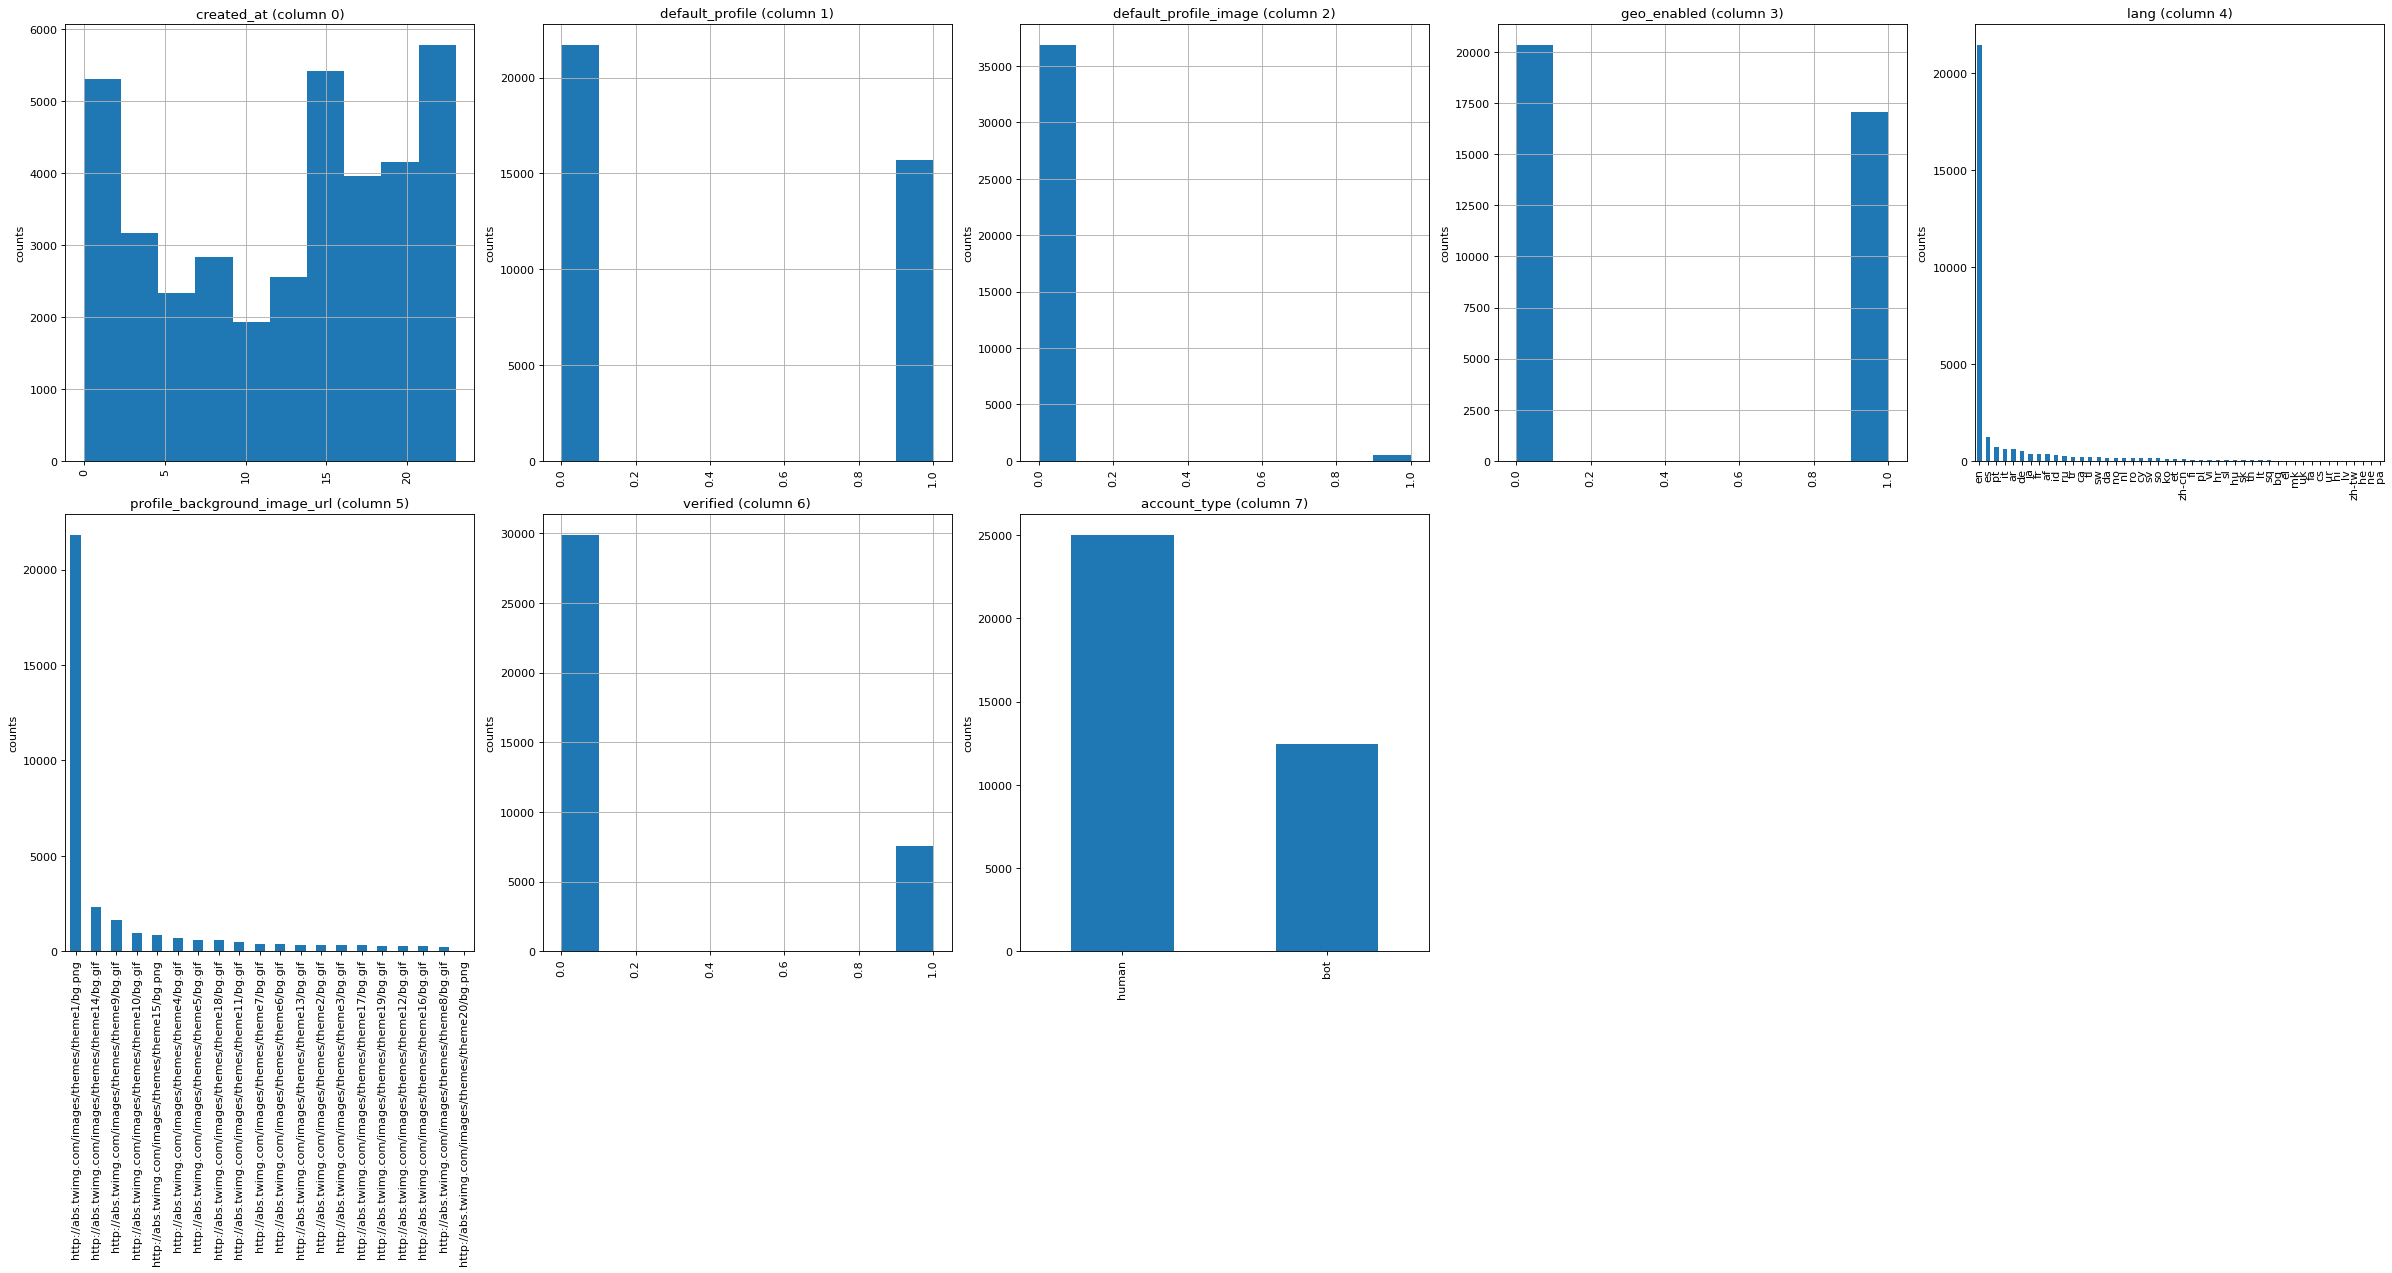

In [31]:
plotPerColumnDistribution(df, 10, 5)

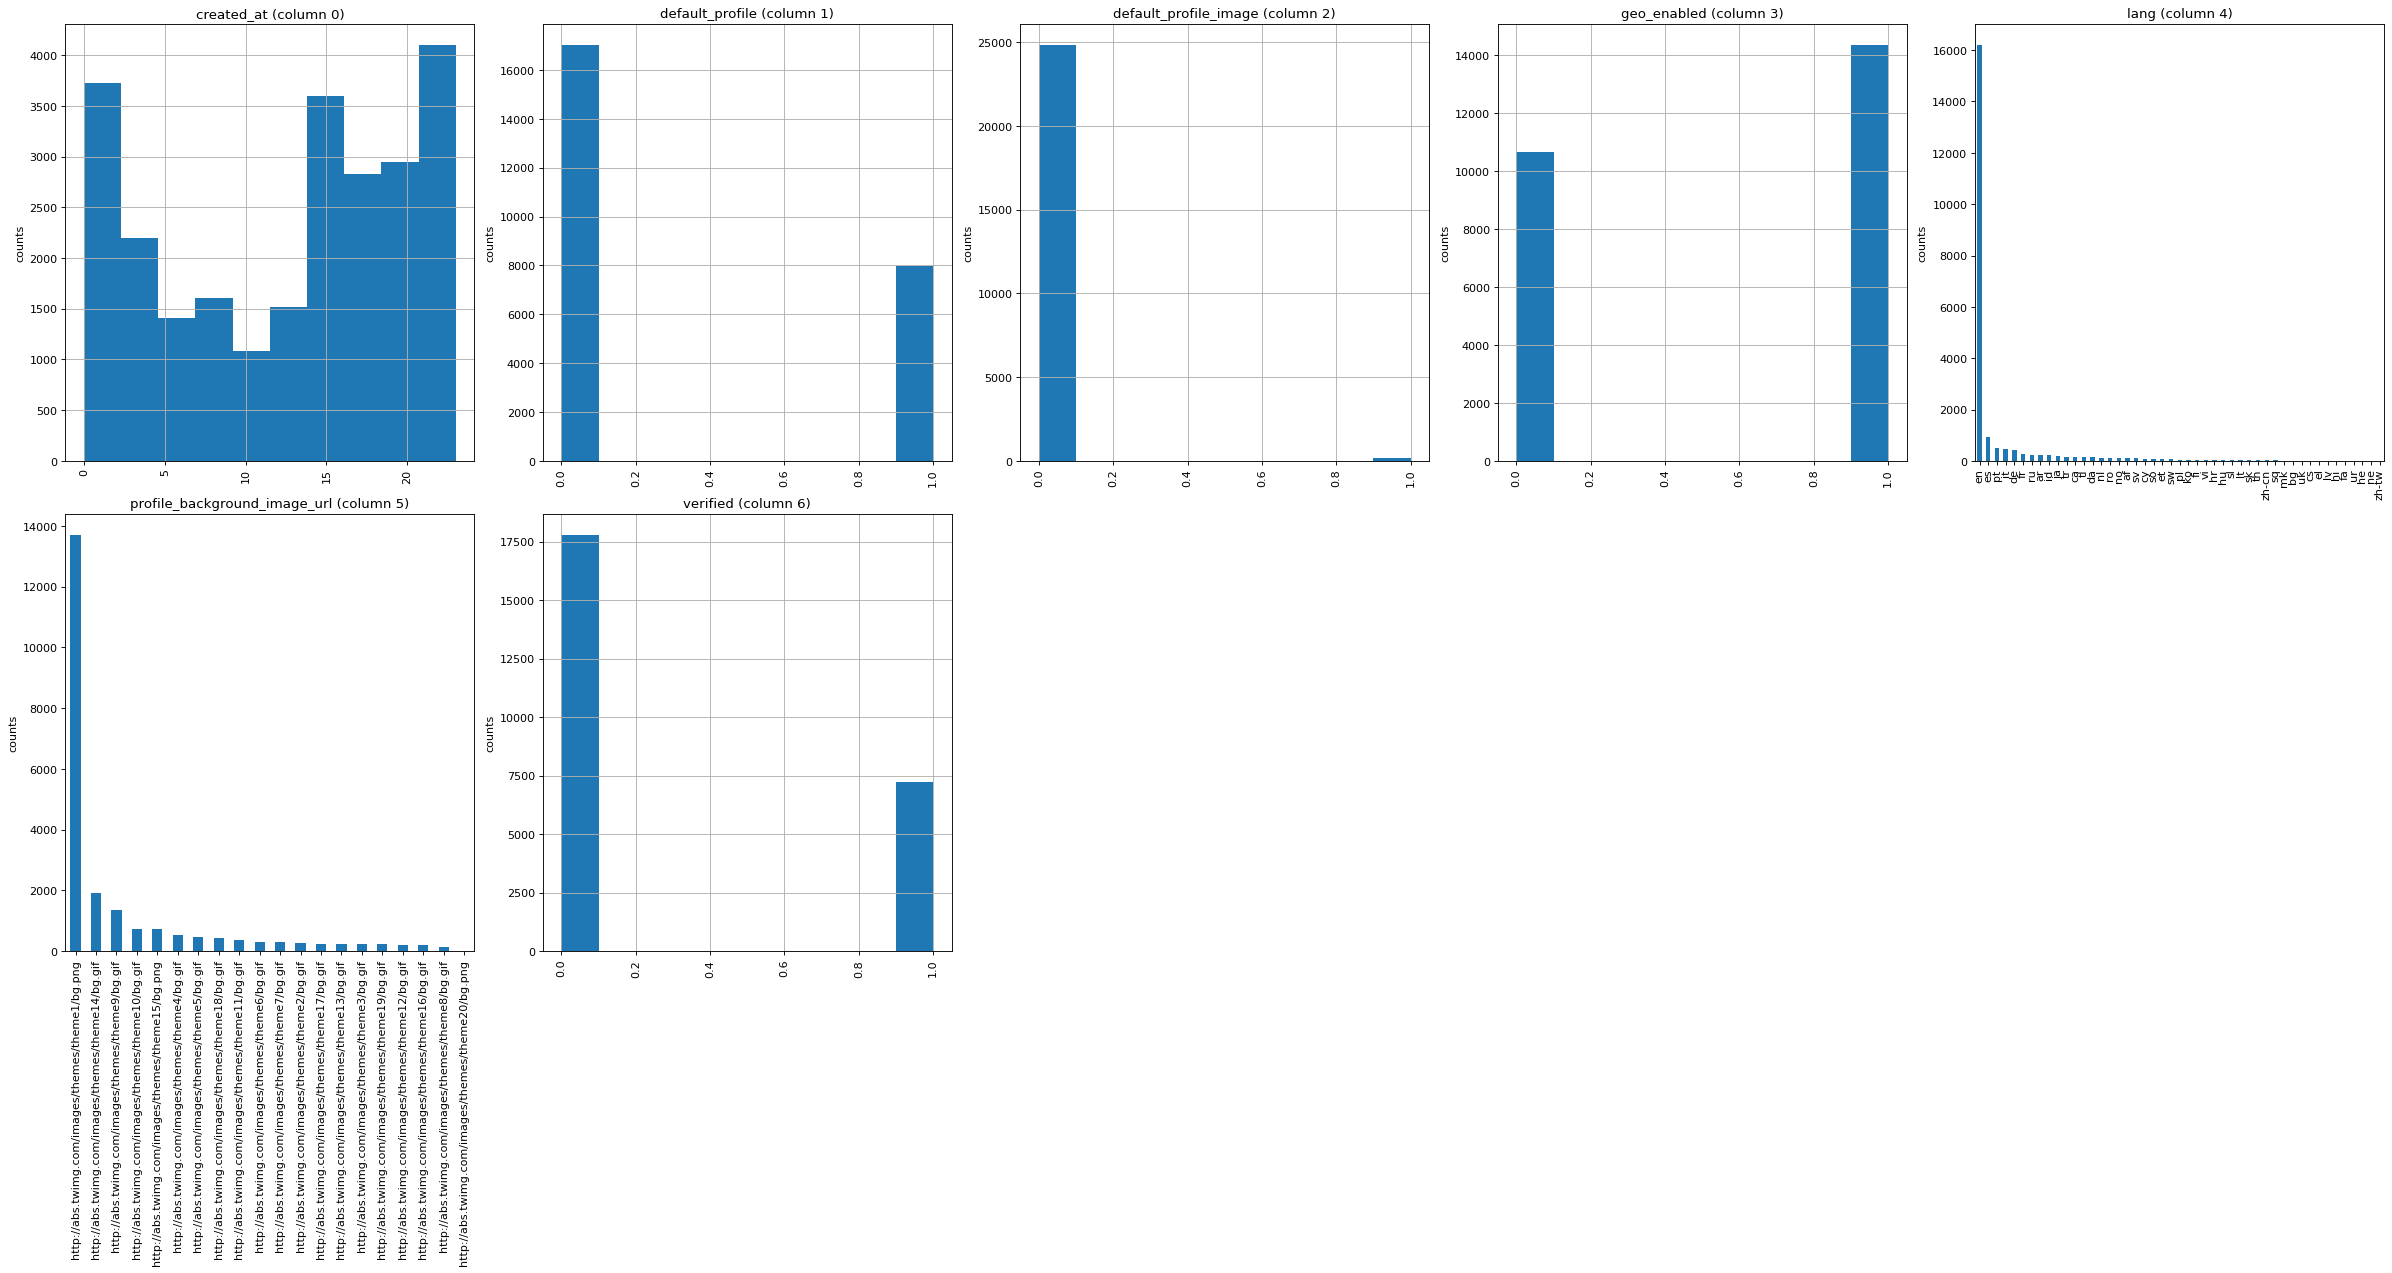

In [32]:
plotPerColumnDistribution(human_df, 10, 5)

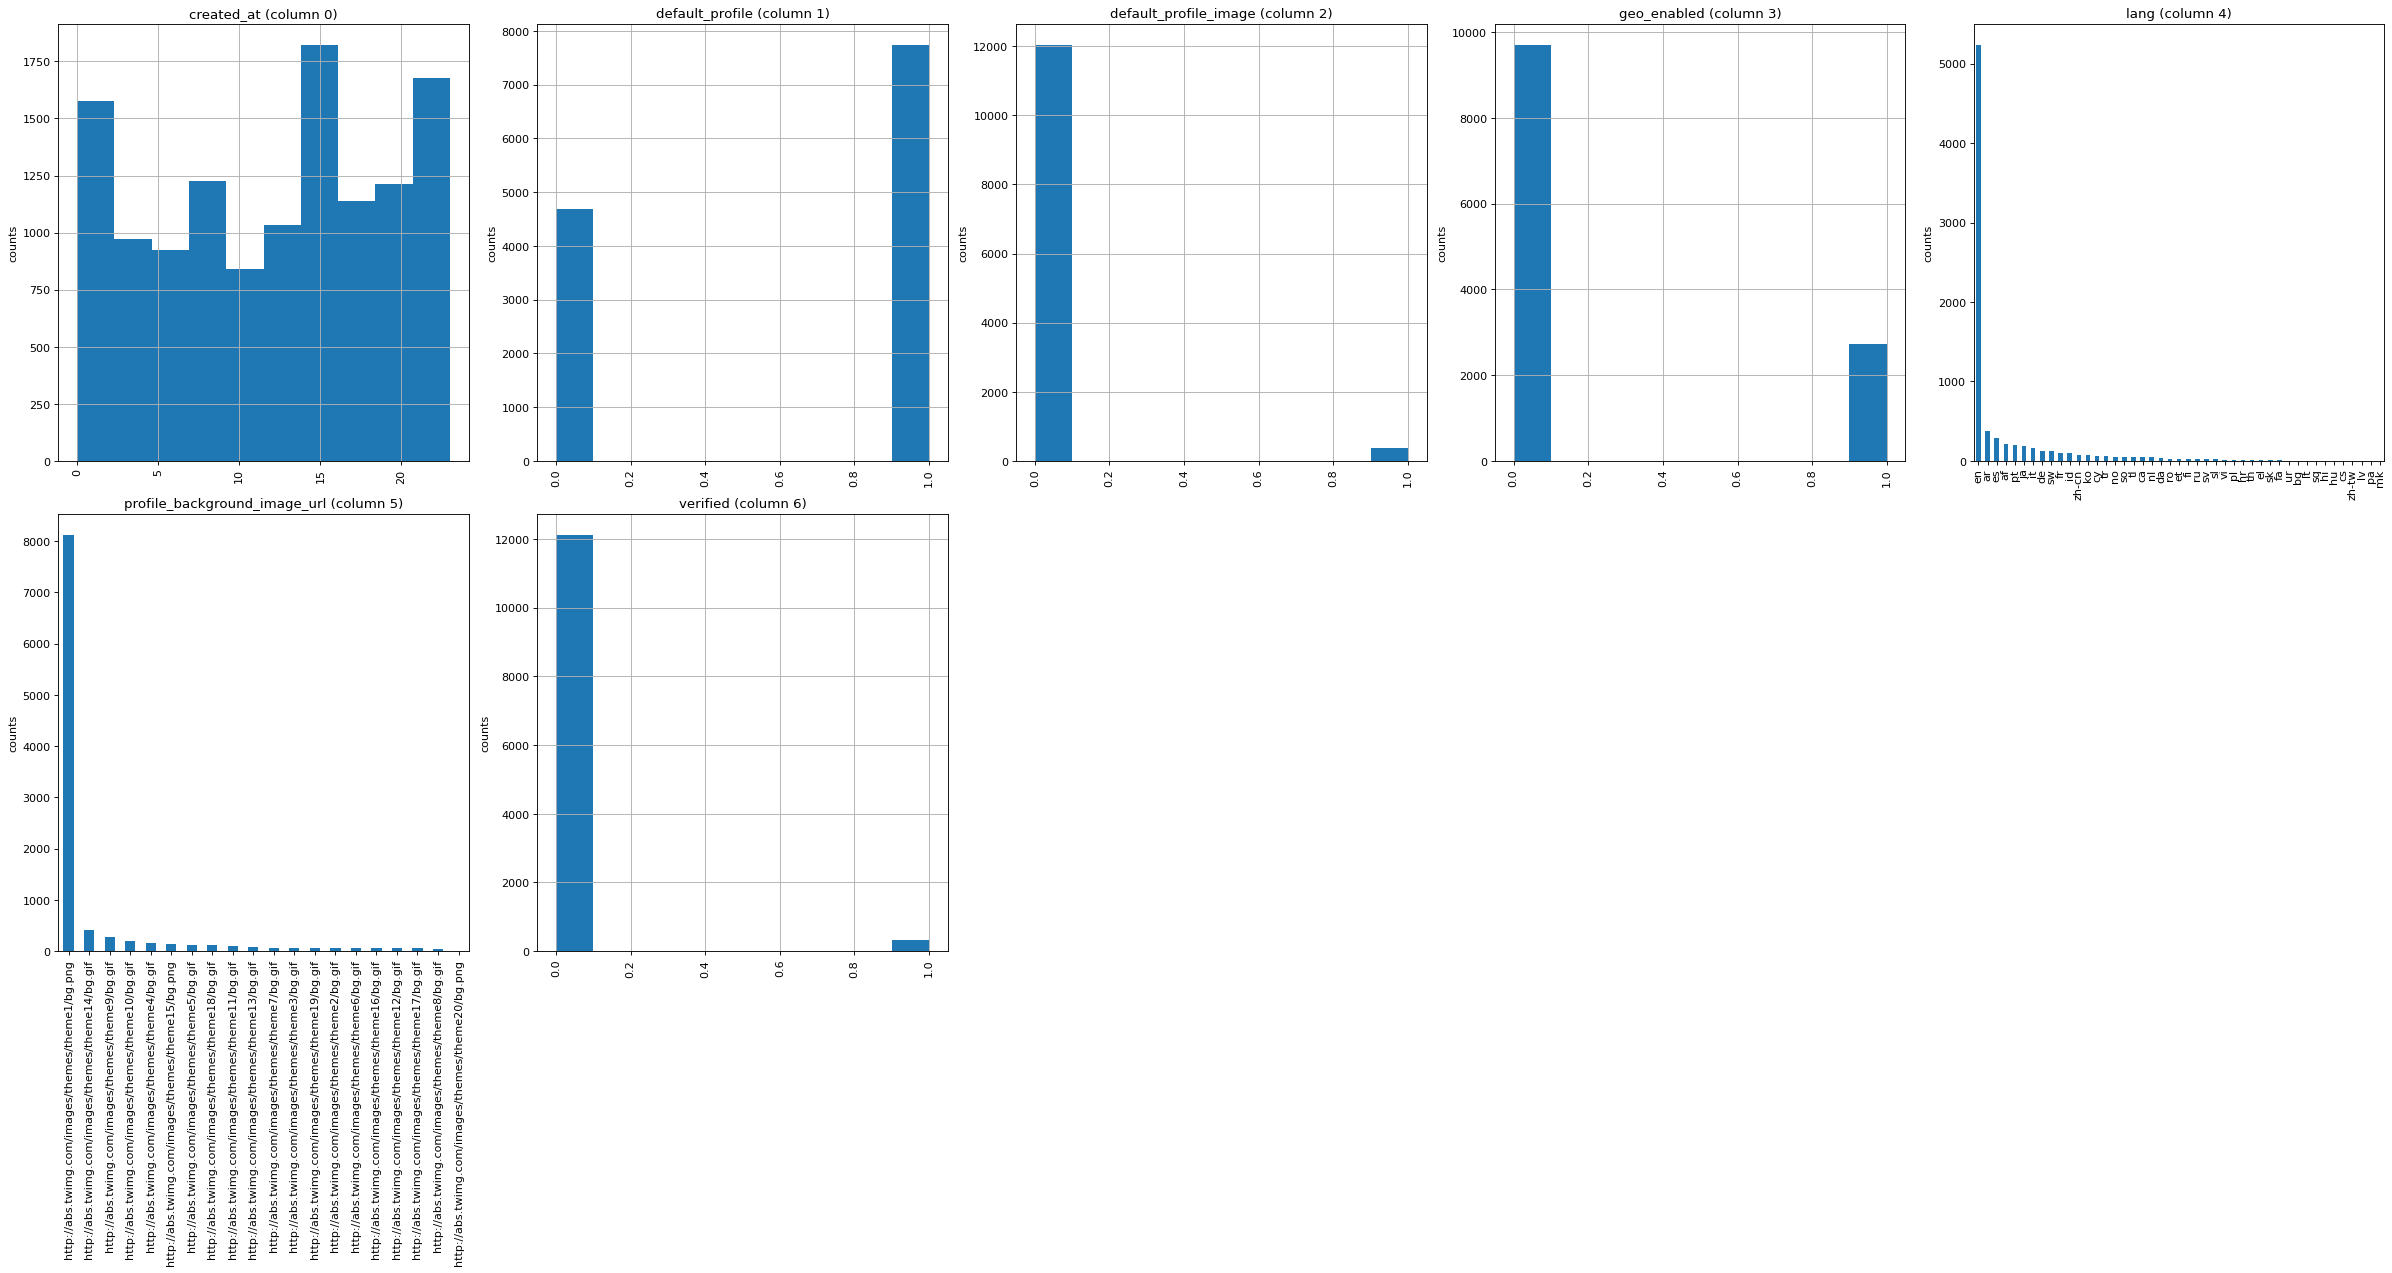

In [33]:
plotPerColumnDistribution(bot_df, 10, 5)

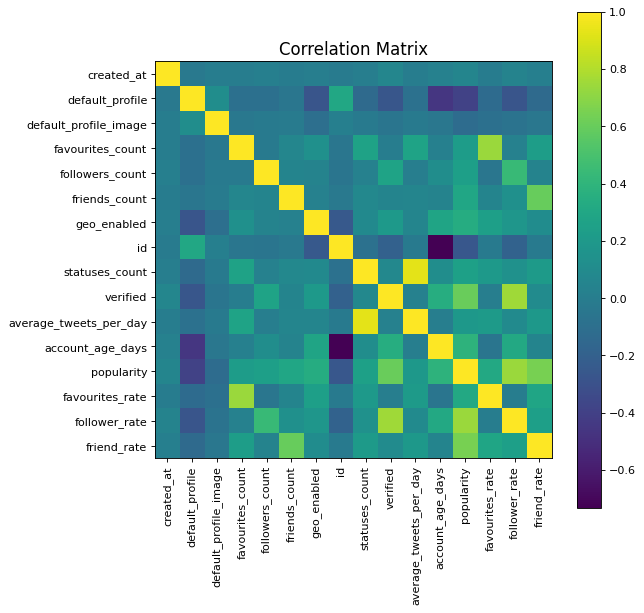

In [34]:
plotCorrelationMatrix(df, 8)

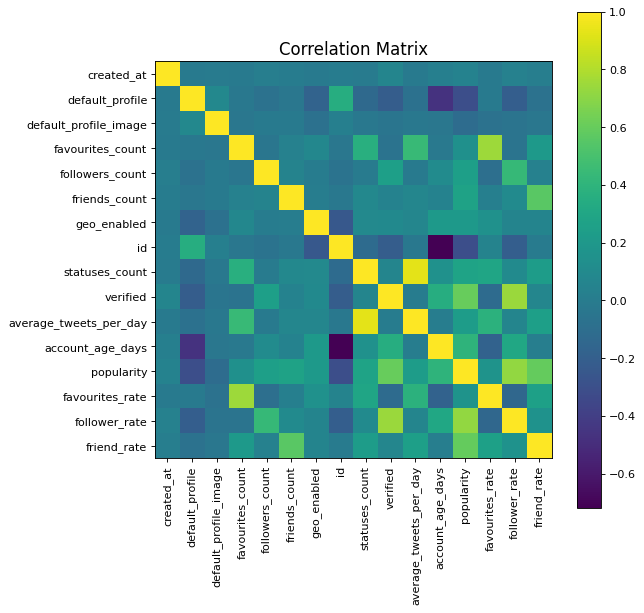

In [35]:
plotCorrelationMatrix(human_df, 8)

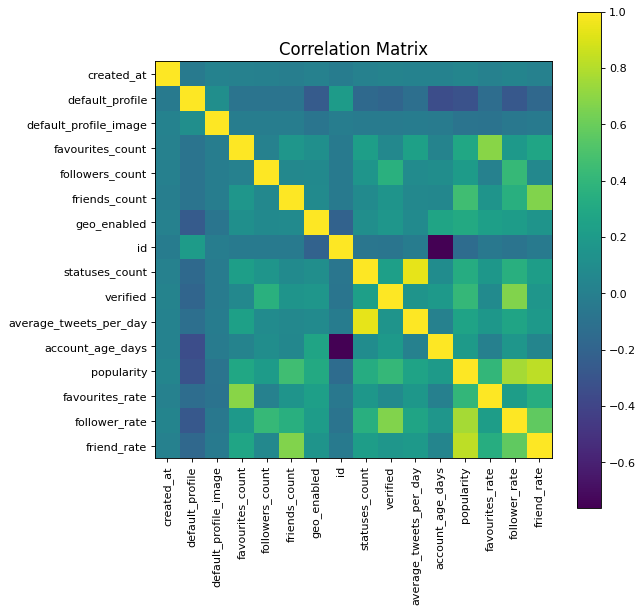

In [36]:
plotCorrelationMatrix(bot_df, 8)

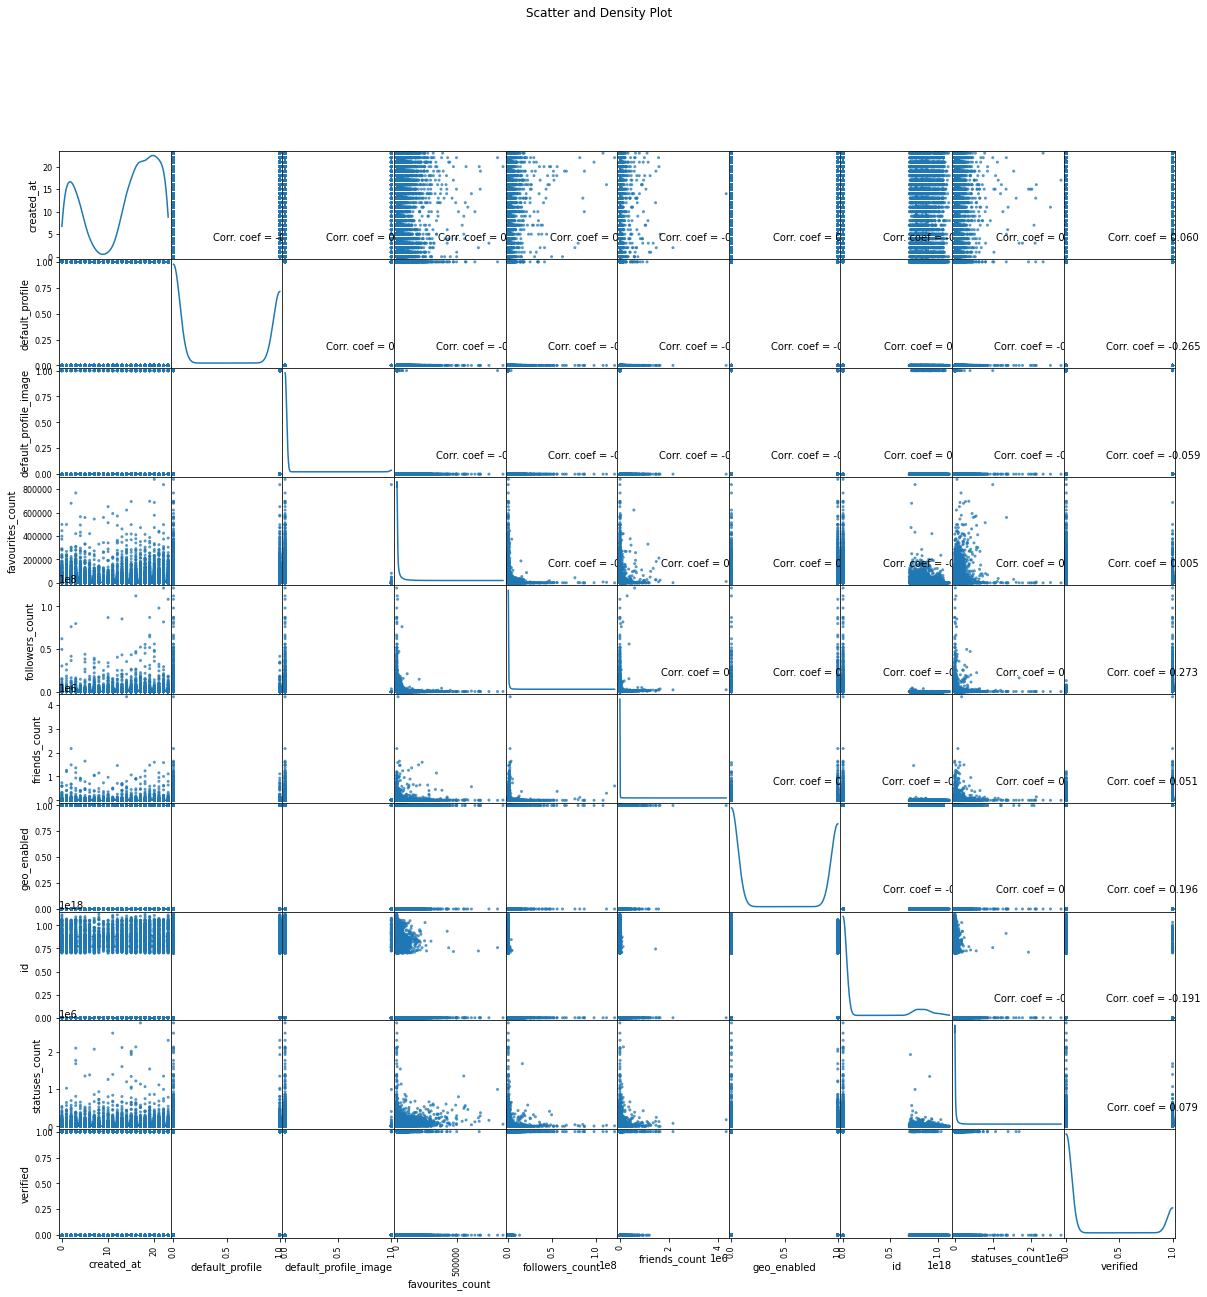

In [37]:
plotScatterMatrix(df, 20, 10)

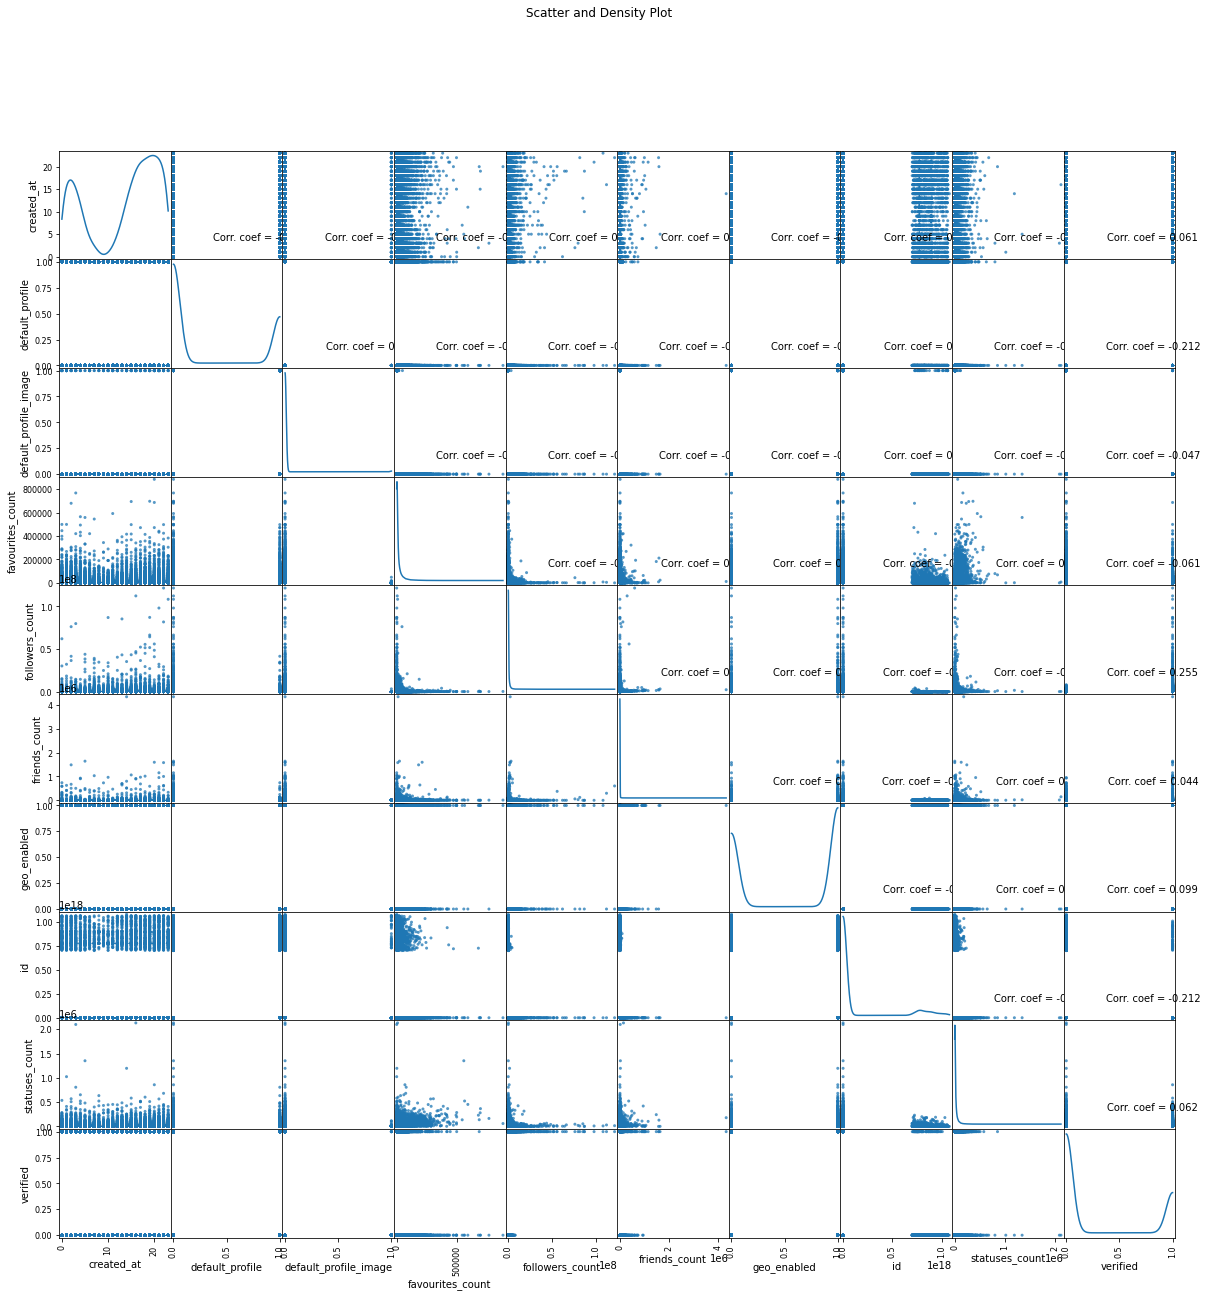

In [38]:
plotScatterMatrix(human_df, 20, 10)

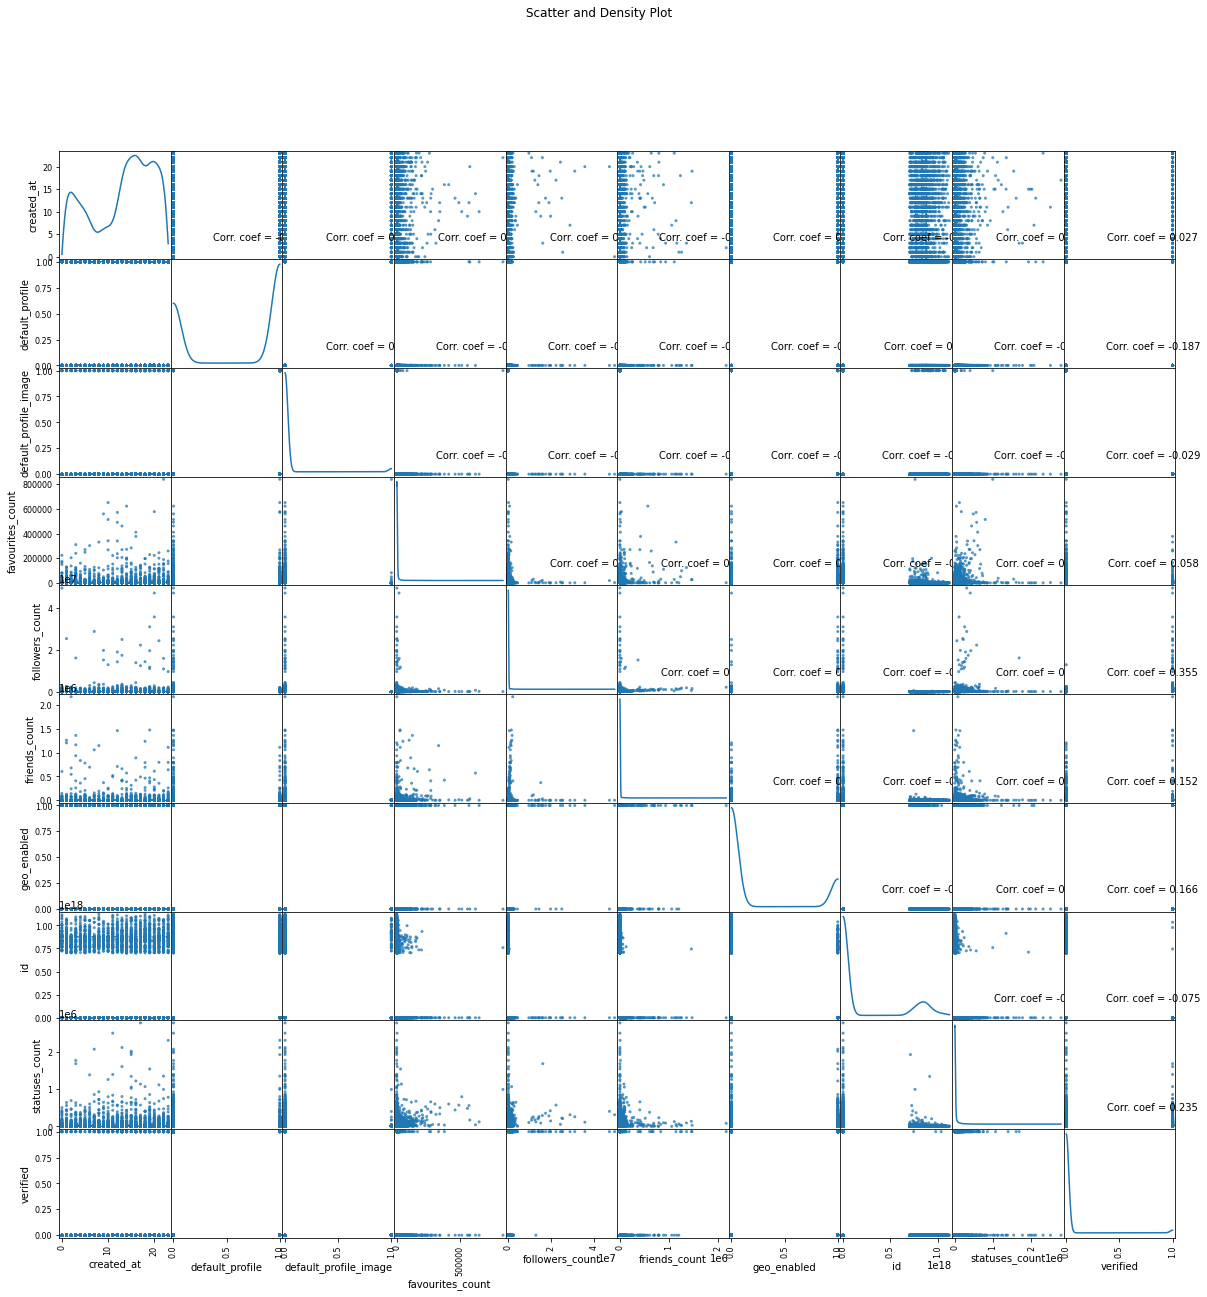

In [39]:
plotScatterMatrix(bot_df, 20, 10)

In [40]:
# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(
    df=df, column=grouped, palette=palette)

### Observation 3: human比bot更受欢迎（互粉账号多）

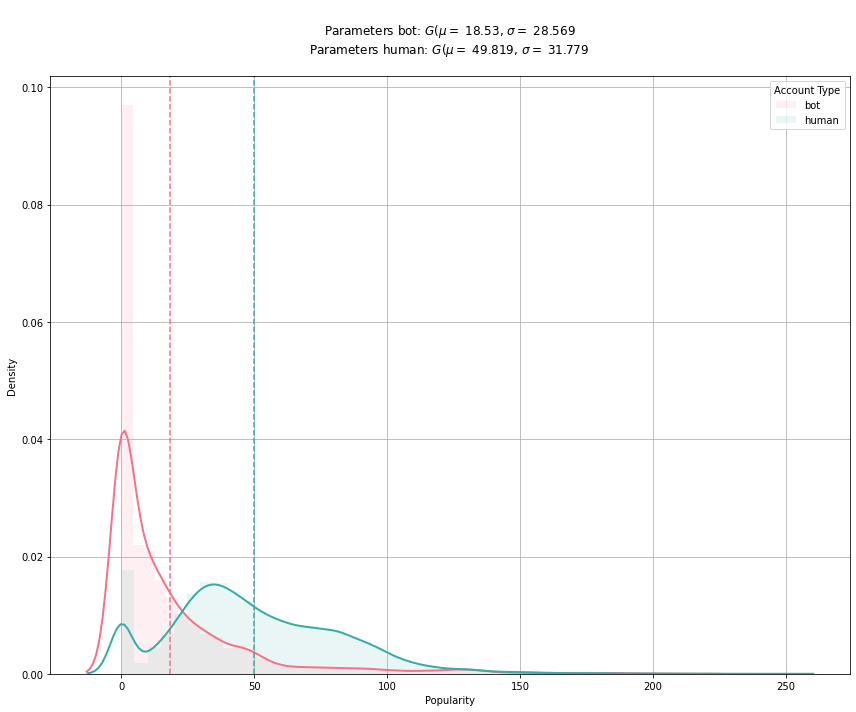

In [41]:
target: str = "popularity"  
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

### Observation 4: human比bot平均每天发推数和状态数，favorite数更集中稳定</h3>

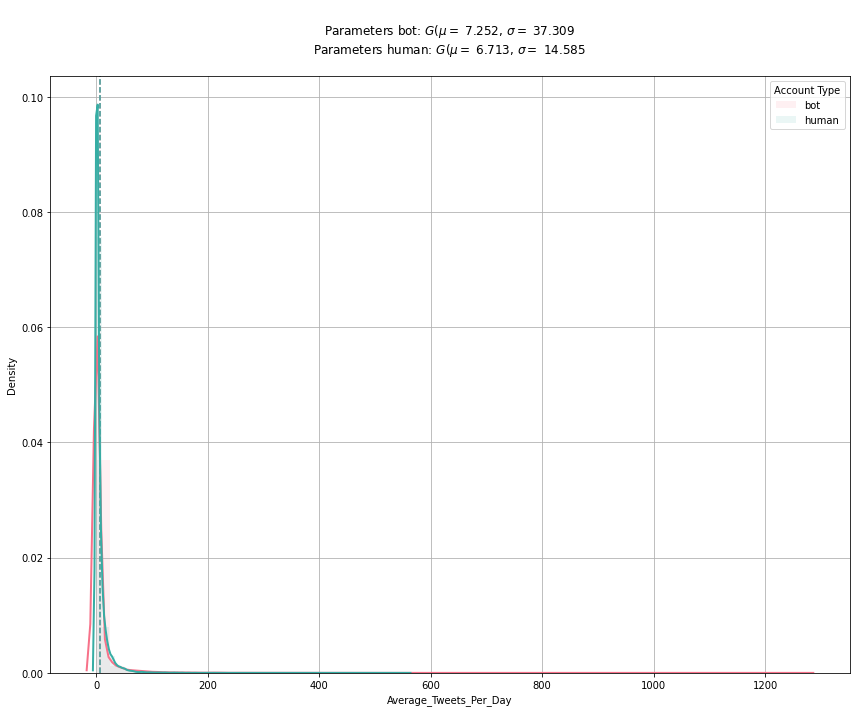

In [42]:
target: str = "average_tweets_per_day"  
# Extract histograms
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

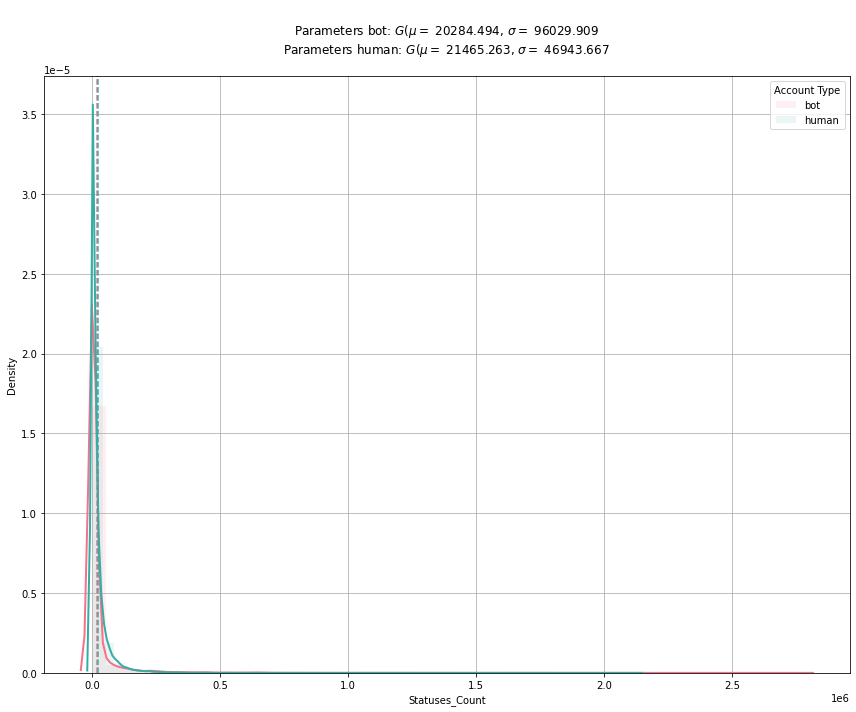

In [43]:
target: str = "statuses_count"  
# Extract histograms
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

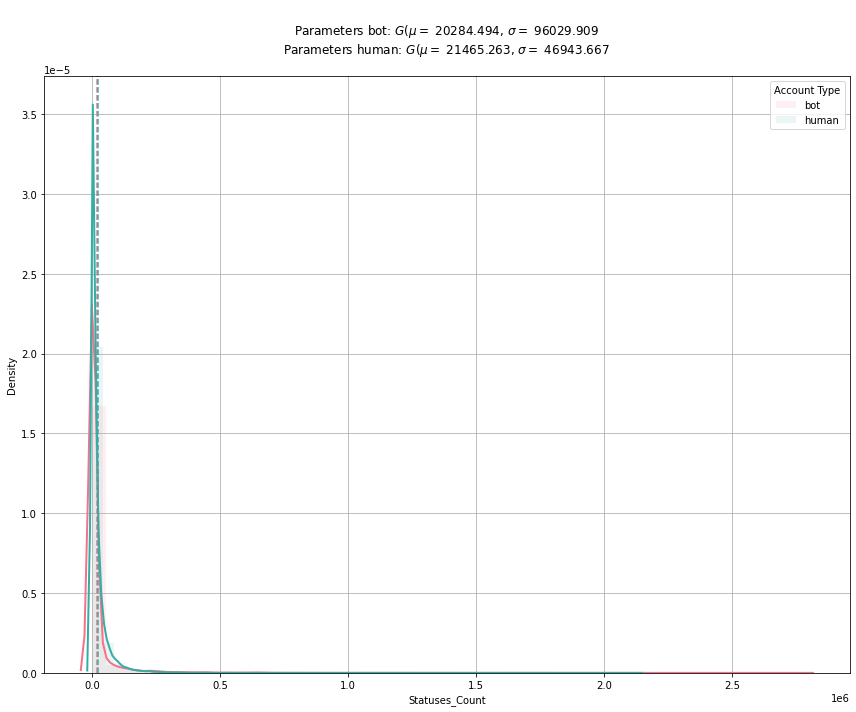

In [44]:
target: str = "statuses_count"  
# Extract histograms
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

### Observation 5: human比bot的活跃程度更高</h3>

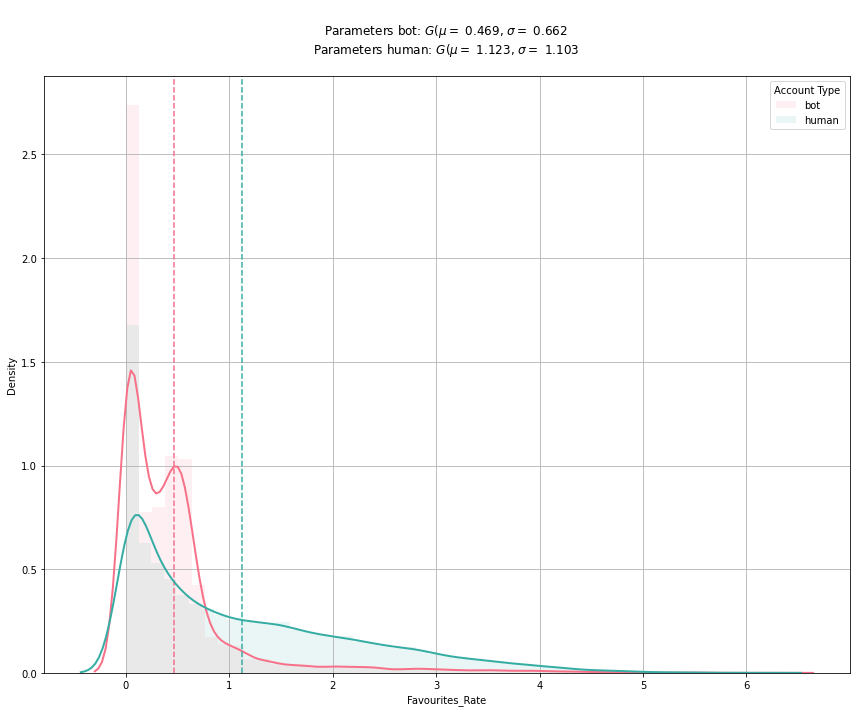

In [45]:
target: str = 'favourites_rate'
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

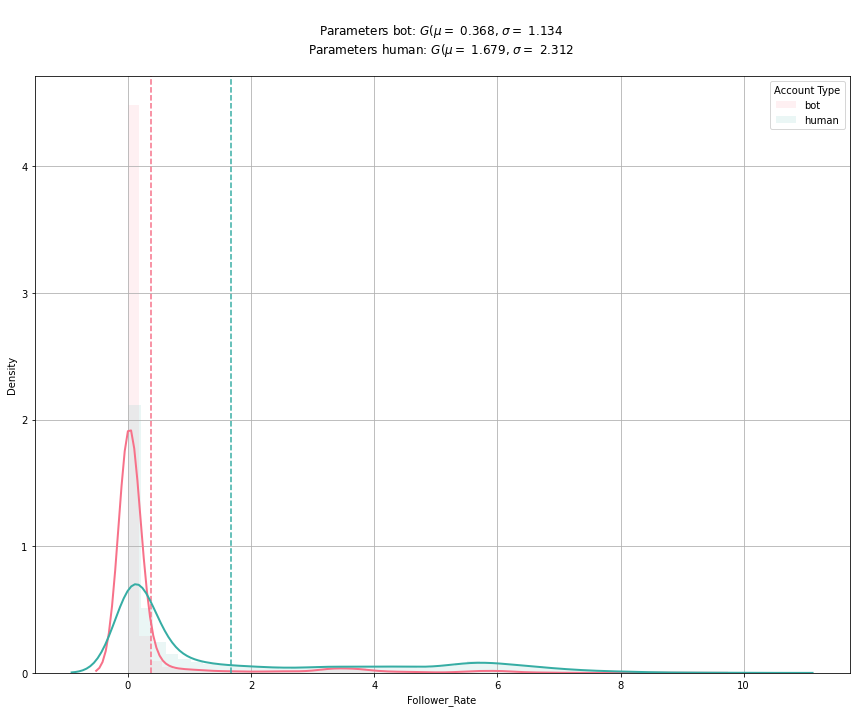

In [46]:
target: str = 'follower_rate'
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

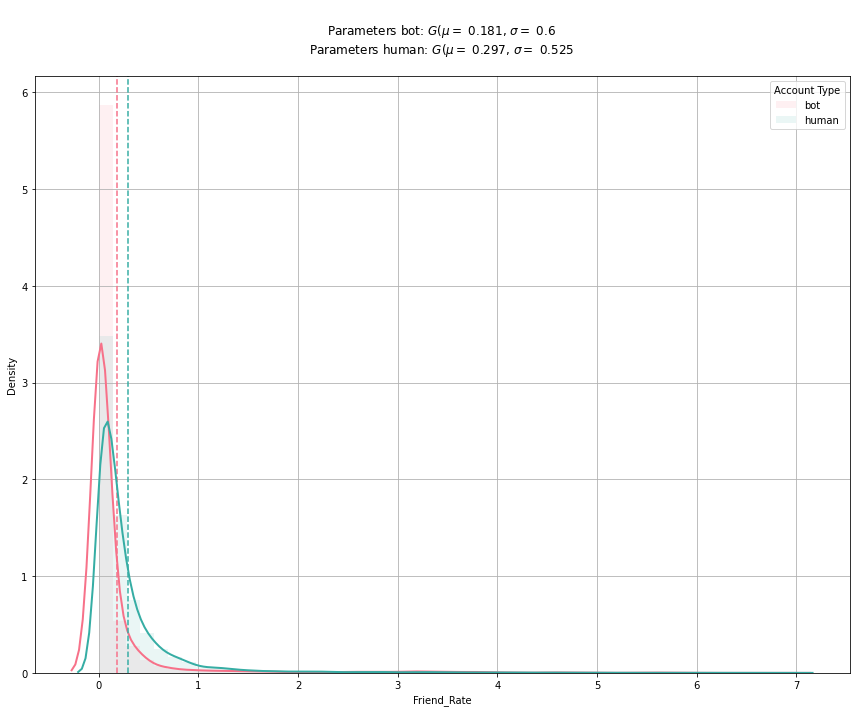

In [47]:
target: str = 'friend_rate'
plot_multiple_histograms(data=df, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

### Observation 6: 真实用户与机器人的账号创建时间规律不同，各个时段创建的机器人账号数量基本相同，而真实用户账号有明显起伏

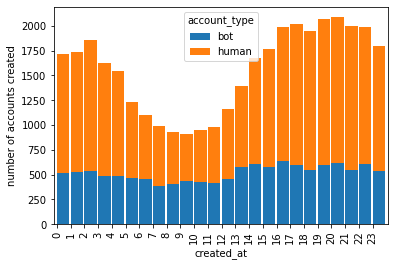

In [48]:
create_time_bar(df)

### Observation 7: 真实用户verified为True的比例远多于机器人</h3>

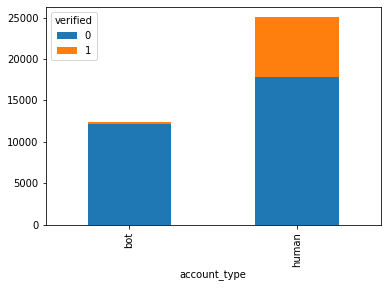

In [49]:
verified_bar(df)

## Save Data for Model Implementation



In [63]:
from sklearn.model_selection import train_test_split

# y的编码
df['bot_or_not'] = df.apply(encode_bot_or_not, axis=1)
df.to_csv('data.csv')


#写入csv
# train_df = pd.concat([train_X, train_y], axis=1)
# train_df.to_csv('train.csv', index=0)
# test_df = pd.concat([test_X, test_y], axis=1)
# test_df.to_csv('test.csv', index=0)